In [ ]:
pip install numpy scipy matplotlib bruges wiggle

  Preparing metadata (setup.py) ... done
  Created wheel for wiggle: filename=wiggle-0.1.0-py3-none-any.whl size=3640 sha256=5d27d3d45af62d9d1cb9692d4b9006a8b185ad2cb71751db676995544af788ef
  Stored in directory: /root/.cache/pip/wheels/ab/f6/32/1ca3789660ef9feb0ca5be0e3c546c400a2041fb75d58873fc
Successfully built wiggle


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import bruges.filters.wavelets as w
import scipy
import scipy.signal
from wiggle import wiggle

In [ ]:
plt.rcParams.update({'font.size': 32})

In [ ]:
############################################################################################################################################################
# Code inspired by: Wu et al, FaultSeg3D: Using synthetic data sets to train an end-to-end convolutional neural network for 3D seismic fault segmentation, #
# Geophysics 84(3):IM35–IM45 DOI: 10.1190/geo2018-0646.1                                                                                                   #
############################################################################################################################################################


#Generate velocity models:
## Input:
### dz      --> number of z point:                 type=int
### dx      --> number of x point:                 type=int
### range_v --> minimum and max velocity:          type = list [int, int]
### interf  --> number of ground strata:           type=int
### V_init  --> Velocity value of the first layer: type=int
## Output:
### v_mod: nuppy array with dims [dz, dx]:         type=Float32
#


def gen_pan(dz, dx, range_v, interf, V_init):
	# Define first shift S1
	# S1 is a linear shift over dx: [y = mx + q] with q = -m/2 . This allow us to keep the half part of the horizon in the desired place.
	def S1(dx):
		shiftk = np.zeros(dx)
		m = (np.random.random(1)-0.5)*50		# generate a random m with boundary values of [-25, 25]
		q = -m*(0.5)					# adjust q so that at shiftk[dx/2]=0
		for i in range(dx):
			shiftk[i] = m * (i/dx) + q		# compute over each dx point
		return shiftk
	# define second shift S2
	# S2 is a shift computed through a sum of N (random choosen between [5, 15]) box distribution.
	def S2(dx):
		N = np.random.randint(5,15)
		def gaussian(x, b, mu, sig):
			return b * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
		x = np.linspace(0, 1, dx)
		shiftk2 = np.zeros(dx)
		for i in range(N):
			b = np.random.random(1)*15
			mu = np.random.random(1)
			sig = (np.random.random(1)/3)+0.1
			shiftk2 = shiftk2 + gaussian(x,  b, mu, sig)
		return shiftk2
	v_mod= np.zeros((dz, dx))					# init output matrix
	# We generate interf number of disconitunity as a random value between [0.005*dz, dz], we sort the result and we append 0 at the beginning.
	# From depth[0] to depth[1] we'll impose velocity as V_init
	depth  = np.append(0, np.sort(np.random.randint(int(dz*0.05), dz*0.9, interf)))		# generate depth of the discontinuity.
	v      = np.append(V_init, np.random.rand(interf)*(range_v[1]-range_v[0])+range_v[0])  	# generate random velocity in range [Vmin, Vmax].
	shift1 = np.zeros((interf, dx)); shift2 = np.zeros((interf, dx))			# init shift1 and shift2 matrix for each interface.
	for j in range(interf): 								# for each interface, compute shift1 and shift2
		shift1[j, :] = S1(dx)
		shift2[j, :] = S2(dx)
	shift1 = np.append(np.zeros((1, dx)), shift1, axis=0)*(dz/256)				# Aappend a 0 at the beginning (no shift) and apply a norm factor (dz/256)
	shift2 = np.append(np.zeros((1, dx)), shift2, axis=0)*(dz/256)				# both on shift1 and shift2
	for i in range(interf+1):								# for each discontinuity:
		for j in range(dx):								# for each dx:
			# generate velocity model by adding shift1 and shift2 to the random depth and assigne it to corresponding random velocity
			v_mod[(np.int(depth[i]+shift1[i,j]+shift2[i,j])):, j] = v[i]
	# compute reflection coefficient ((V1-V2)/(V1+V2))
	r_coeff = np.diff(v_mod, axis=0)/(x[:-1, :]+x[1:, :])
	return v_mod, r_coeff



# generate a random frequency wavelet
def wave_fixed(f = 15, dt = 0.002):
  # create a ricker with bruges.filters.wavelets
  # see https://bruges.readthedocs.io/api/bruges.filters.wavelets.html for info
  wave, _ = w.ricker(1, dt, f)
  # define when the wavelet starts and cut at that value (to avoid shifts)
  cut = np.where(wave<-10**-4)[0][0]
  wave = wave[cut:]
  # find maximun value (usefull to make reference output to maximum phase)
  a=np.where(np.max(wave)==wave)[0][0]
  return wave, a

<ipython-input-193-fb640f1c4c7e>:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  v_mod[(np.int(depth[i]+shift1[i,j]+shift2[i,j])):, j] = v[i]


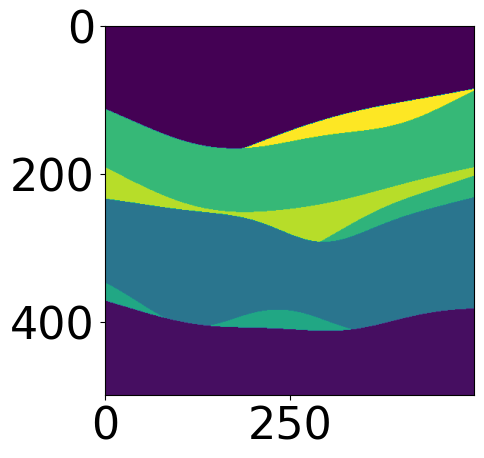

In [ ]:
v, refl = gen_pan(500, 500, [1000, 5000], 8, 1000)

plt.imshow(v)

In [ ]:
f = 15
dt = 0.002

In [ ]:
conv_data = np.zeros(refl.shape)
wave, a = wave_fixed(f, dt)

for i in range(conv_data.shape[1]):
  conv_data[:, i] = scipy.signal.convolve(refl[:, i], wave)[a:refl.shape[0]+a]

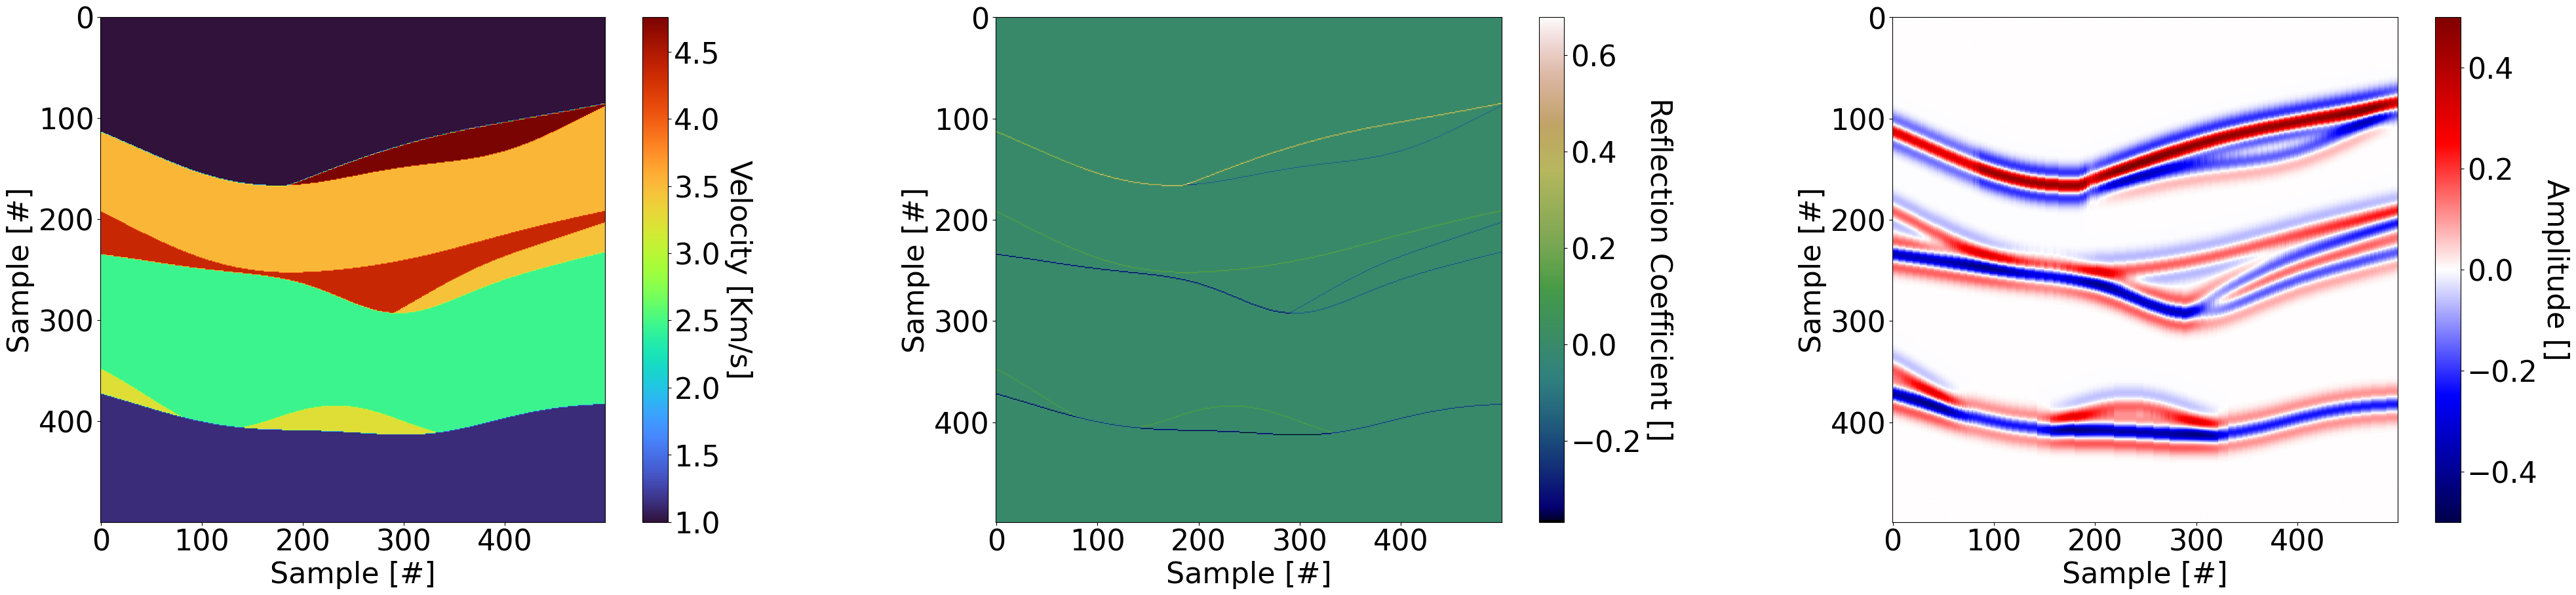

In [ ]:
plt.figure(figsize=[50, 10])
plt.subplot(131)
plt.xlabel('Sample [#]')
plt.ylabel('Sample [#]')
im = plt.imshow(v/1000, cmap = 'turbo')
cbar = plt.colorbar(im)
cbar.set_label('Velocity [Km/s]', rotation=270, labelpad=35)

plt.subplot(132)
plt.xlabel('Sample [#]')
plt.ylabel('Sample [#]')
im = plt.imshow(refl, cmap = 'gist_earth')
cbar = plt.colorbar(im)
cbar.set_label('Reflection Coefficient []', rotation=270, labelpad=35)

plt.subplot(133)
plt.xlabel('Sample [#]')
plt.ylabel('Sample [#]')
im = plt.imshow(conv_data, cmap = 'seismic', vmin =-.5, vmax = .5)
cbar = plt.colorbar(im)
cbar.set_label('Amplitude []', rotation=270, labelpad=35)
plt.savefig('thesis_2.0.png', dpi = 200)

In [ ]:
conv_data_noise = np.zeros(refl.shape)
r_coeff_noise = refl + (np.random.random(conv_data.shape)-0.5)/10

for i in range(conv_data.shape[1]):
  conv_data_noise[:, i] = scipy.signal.convolve(r_coeff_noise[:, i], wave)[a:refl.shape[0]+a]


In [ ]:
conv_data_pre = conv_data + (np.random.random(conv_data.shape)-0.5)/5
conv_data_noise += (np.random.random(conv_data.shape)-0.5)/10

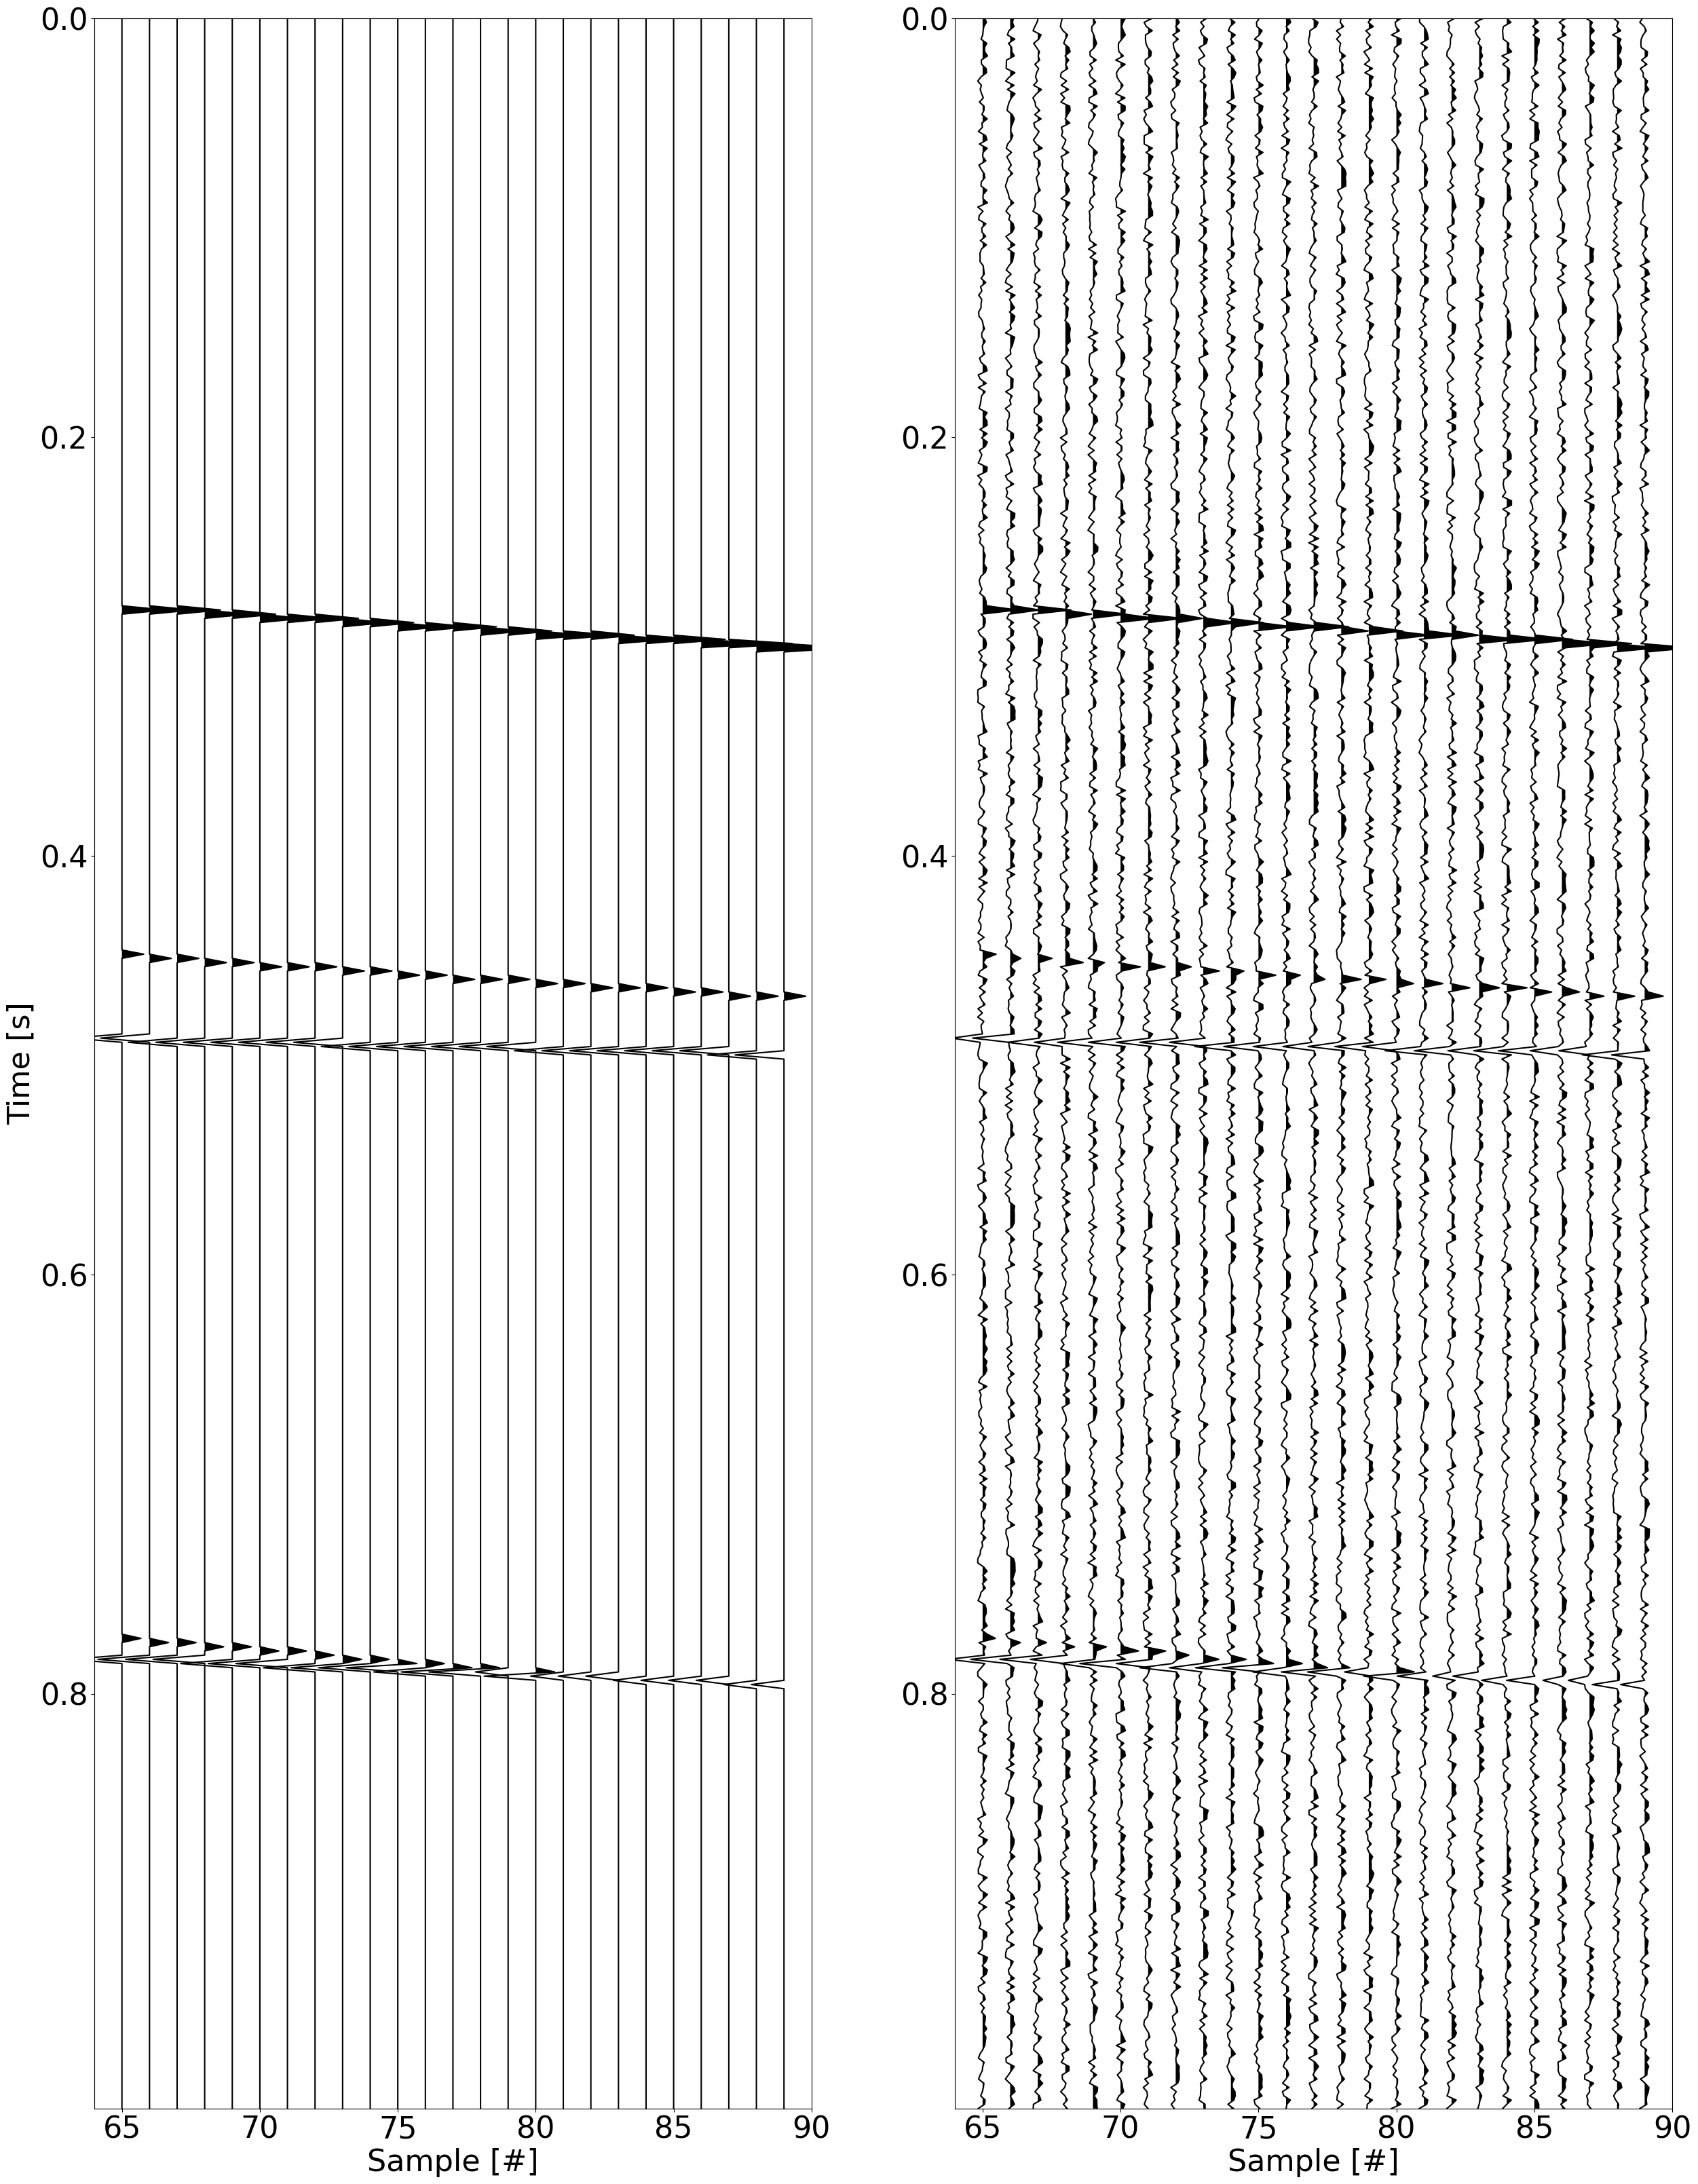

In [ ]:
i = 65

plt.figure(figsize=[30, 40])
plt.subplot(121)
plt.xlabel('Sample [#]')
plt.ylabel('Time [s]')
wiggle(refl[:, i:i+25], np.linspace(0, conv_data.shape[0]*dt, conv_data.shape[0]), np.linspace(i, i+ 24, 25), sf=0.15)
plt.subplot(122)
plt.xlabel('Sample [#]')
wiggle(r_coeff_noise[:, i:i+25], np.linspace(0, conv_data_noise.shape[0]*dt, conv_data_noise.shape[0]), np.linspace(i, i+ 24, 25), sf=0.15)
plt.savefig('thesis_2.1.png', dpi = 200)

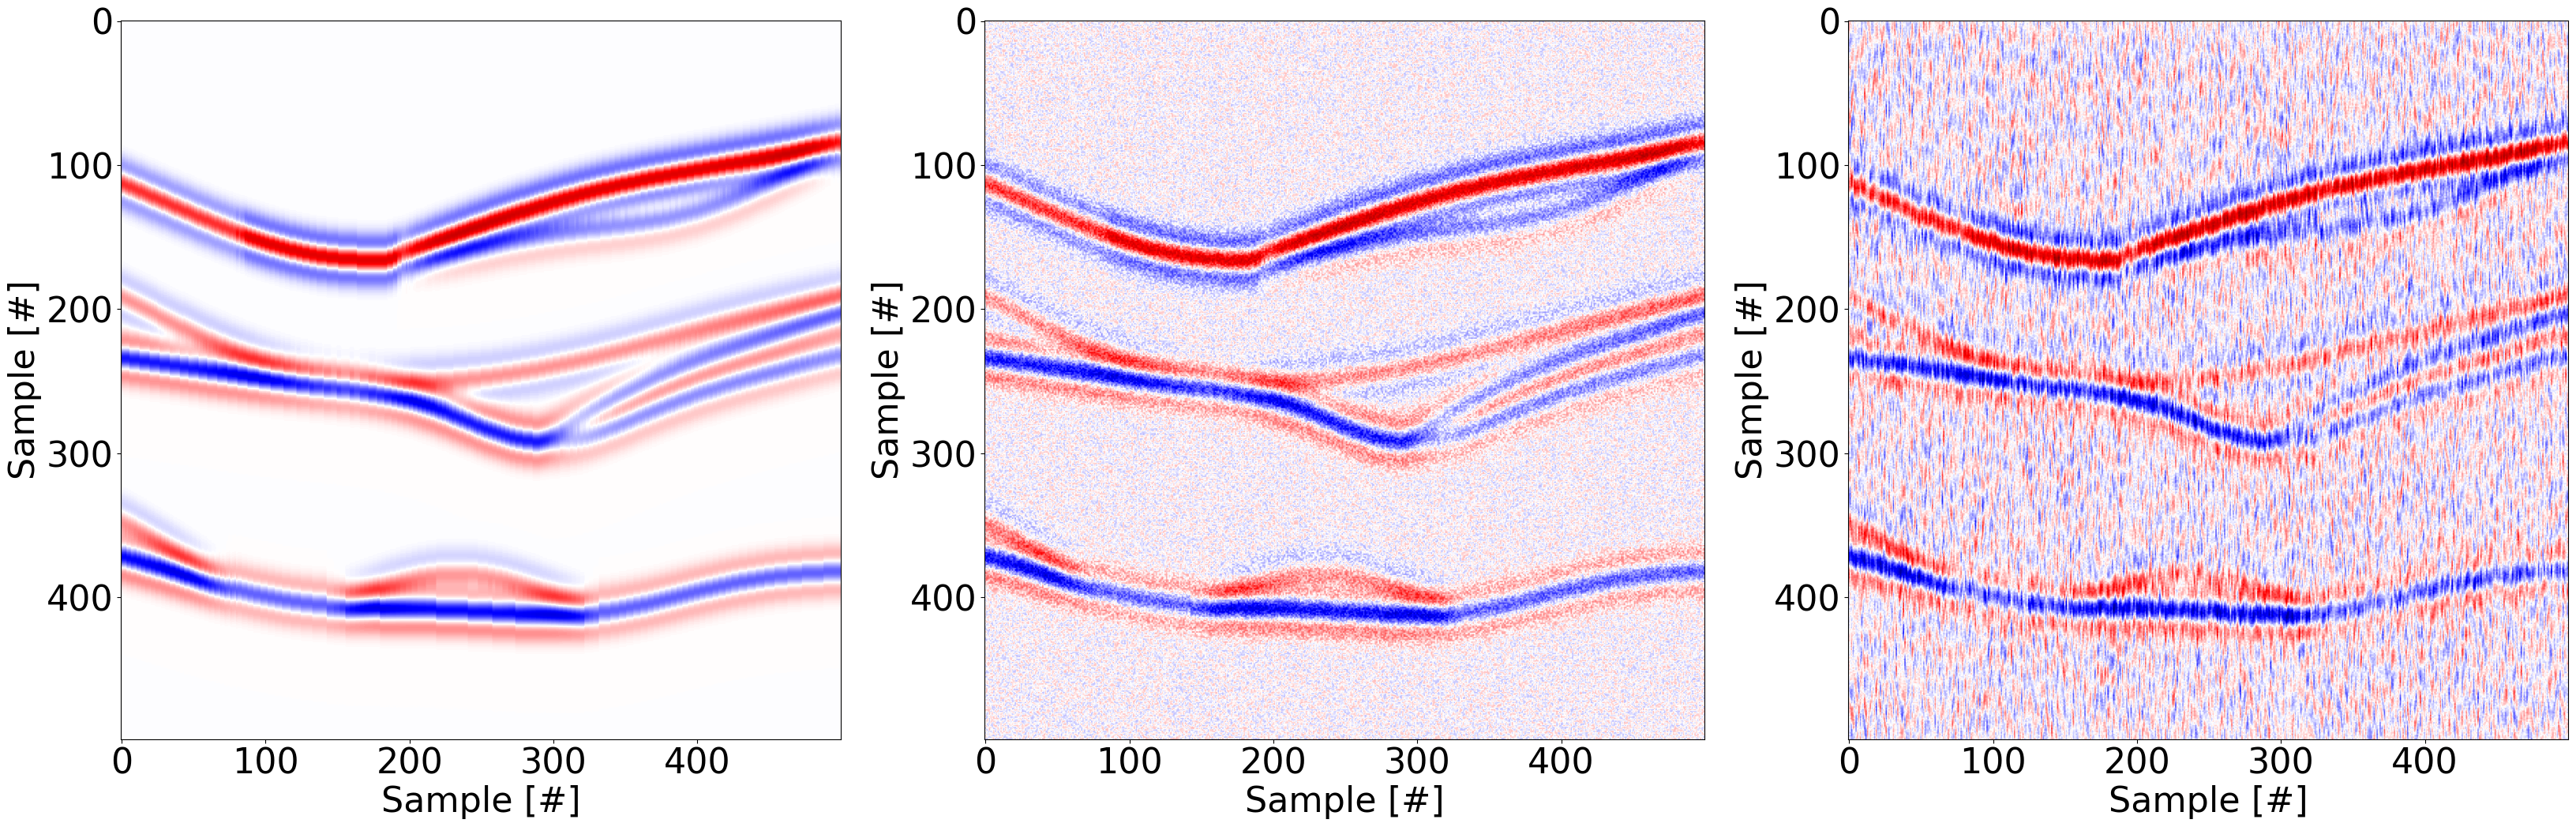

In [ ]:
plt.figure(figsize=[40, 15])
plt.subplot(131)
plt.xlabel('Sample [#]')
plt.ylabel('Sample [#]')
plt.imshow(conv_data, cmap = 'seismic', vmin =-.75, vmax = .75)
plt.subplot(132)
plt.xlabel('Sample [#]')
plt.ylabel('Sample [#]')
plt.imshow(conv_data_pre, cmap = 'seismic', vmin =-.75, vmax = .75)
plt.subplot(133)
plt.xlabel('Sample [#]')
plt.ylabel('Sample [#]')
plt.imshow(conv_data_noise, cmap = 'seismic', vmin =-.75, vmax = .75)
plt.savefig('thesis_2.2.png', dpi = 200)

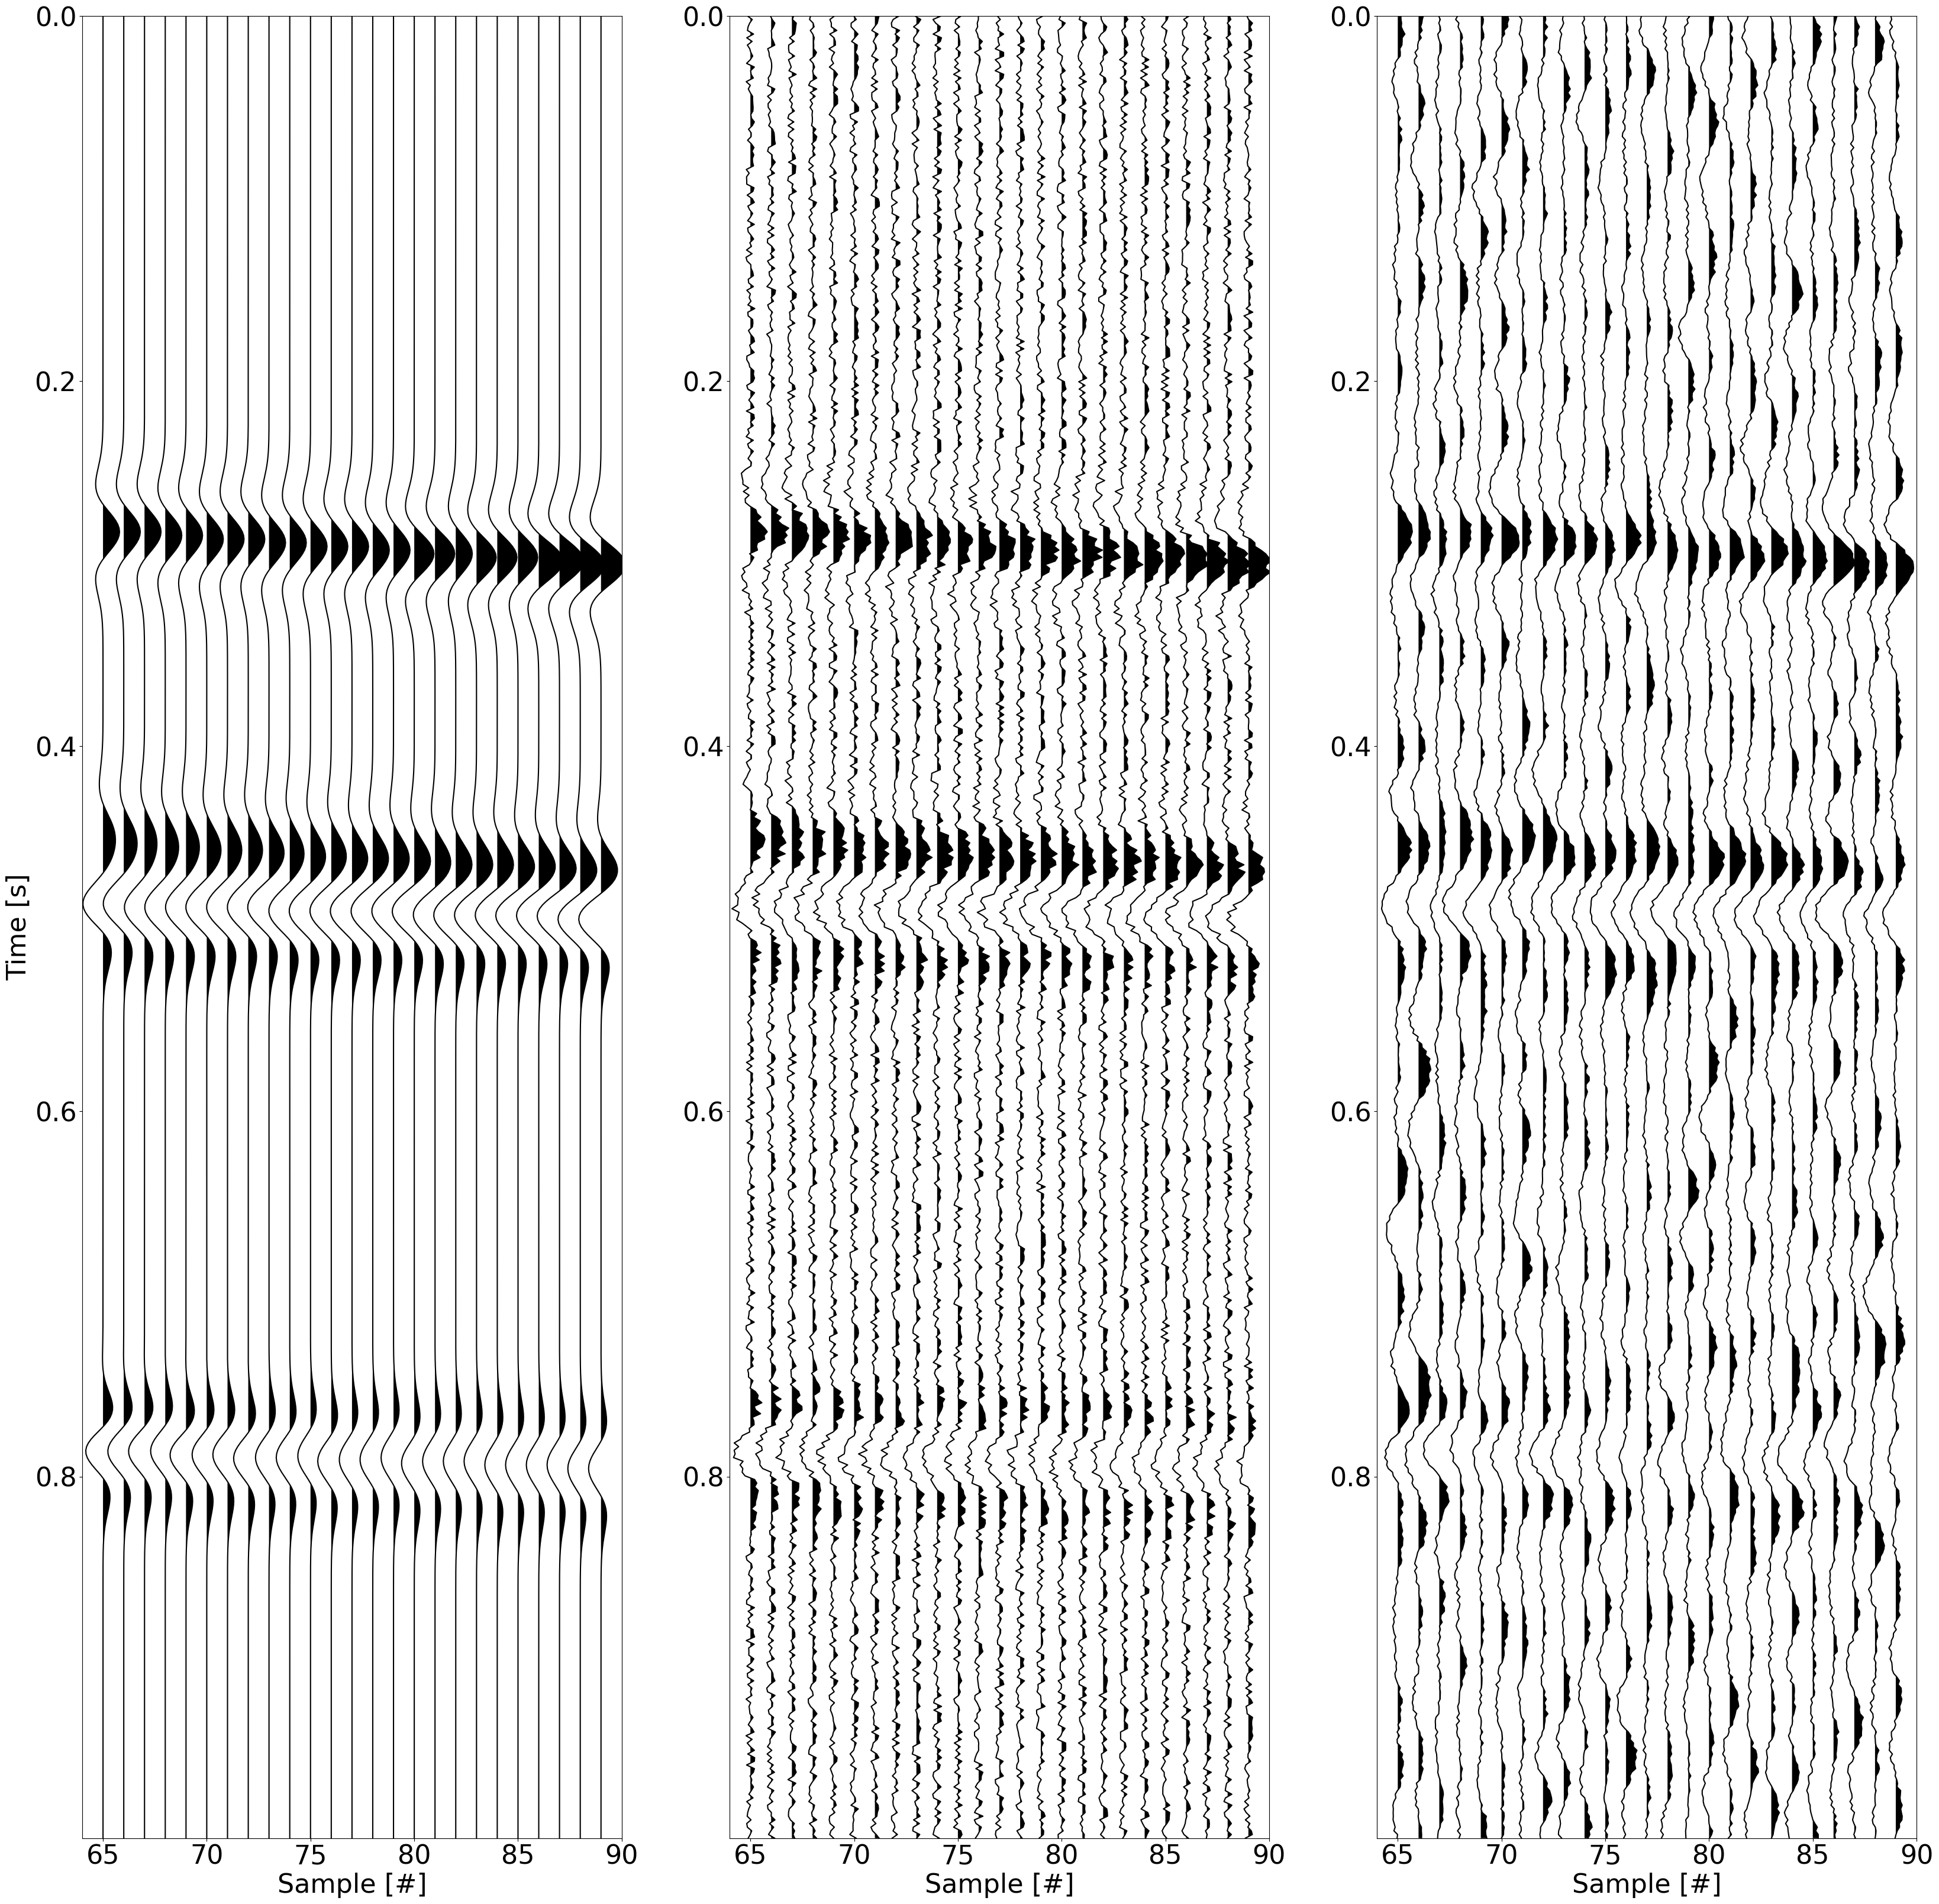

In [ ]:

i = 65

plt.figure(figsize=[40, 40])
plt.subplot(131)
plt.xlabel('Sample [#]')
plt.ylabel('Time [s]')
wiggle(conv_data[:, i:i+25], np.linspace(0, conv_data.shape[0]*dt, conv_data.shape[0]), np.linspace(i, i+ 24, 25), sf=0.25)
plt.subplot(132)
plt.xlabel('Sample [#]')
wiggle(conv_data_pre[:, i:i+25], np.linspace(0, conv_data_pre.shape[0]*dt, conv_data_pre.shape[0]), np.linspace(i, i+ 24, 25), sf=0.25)
plt.subplot(133)
plt.xlabel('Sample [#]')
wiggle(conv_data_noise[:, i:i+25], np.linspace(0, conv_data_noise.shape[0]*dt, conv_data_noise.shape[0]), np.linspace(i, i+ 24, 25), sf=0.25)
plt.savefig('thesis_2.3.png', dpi = 200)